In [182]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

### Identify the Leakage time

In [183]:
data = np.load("data/traces_1.npz", allow_pickle=True)
print(data.files)
print(data['dut_io_computed_data'].dtype)
print(f"Shape of traces captured is {data['wave'].shape}")
print(f"Shape of ciphertext data is {data['dut_io_computed_data'].shape}")
print(f"Shape of plaintext data is {data['dut_io_data'].shape}")

['wave', 'dut_io_data', 'dut_io_computed_data']
int32
Shape of traces captured is (2000, 200)
Shape of ciphertext data is (2000, 16)
Shape of plaintext data is (2000, 16)


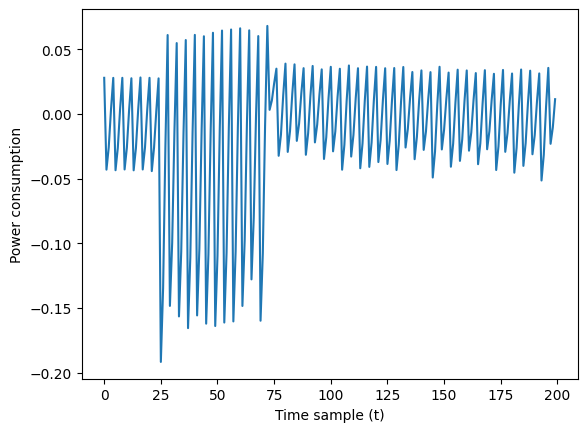

In [184]:
traces = data['wave']
plaintexts = data['dut_io_data']
ciphertexts = data['dut_io_computed_data']
# Average all traces to reduce noise
avg_trace = np.mean(traces, axis=0)  # Shape: (200,)

# Plot the averaged trace
plt.plot(avg_trace)
plt.xlabel("Time sample (t)")
plt.ylabel("Power consumption")
plt.show()

### Automatic Peak Detection with Statistics

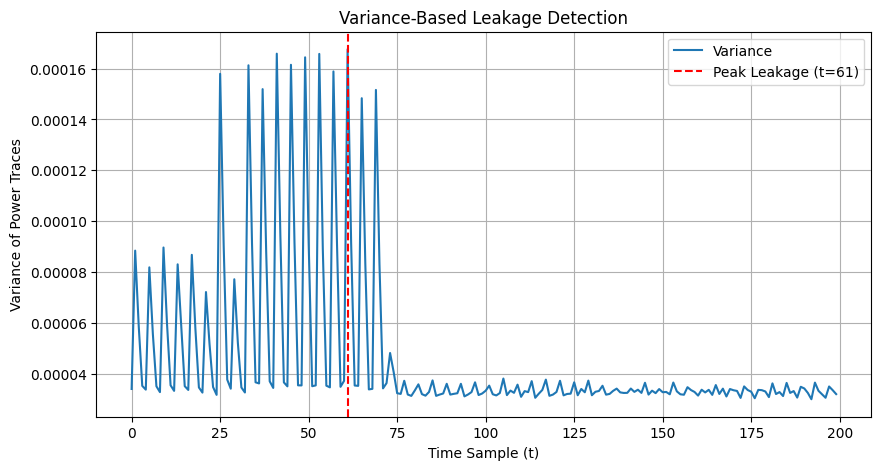

Detected leakage at time sample t = 61


In [185]:
# Compute variance across all traces at each time sample
variance_per_time = np.var(traces, axis=0)  # Shape: (200,)

# Find the time sample with highest variance (most likely leakage point)
leakage_time = np.argmax(variance_per_time)

# Plot variance vs. time to visualize leakage
plt.figure(figsize=(10, 5))
plt.plot(variance_per_time, label='Variance')
plt.axvline(x=leakage_time, color='r', linestyle='--', label=f'Peak Leakage (t={leakage_time})')
plt.xlabel('Time Sample (t)')
plt.ylabel('Variance of Power Traces')
plt.title('Variance-Based Leakage Detection')
plt.legend()
plt.grid()
plt.show()

print(f"Detected leakage at time sample t = {leakage_time}")

In [186]:
# Hypothetical power model (Hamming Weight of S-box output)

# AES S-box for intermediate value calculations
SBOX = np.array([
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16
], dtype=np.uint8)

# Hamming Weight lookup table
HW = np.array([bin(n).count('1') for n in range(256)])

# Hypothetical Power Matrix Construction
H = np.zeros((2000, 256)) # 2000 traces × 256 key guesses
# get the first byte

# Calculate S-box output for ALL 2000 traces
for i in range(2000):
    pt_byte = plaintexts[i, 0].astype(np.uint8)
    for k_guess in range(256):
        sbox_input = pt_byte ^ k_guess
        sbox_output = SBOX[sbox_input]

        # Hamming Weight calculation (explicit loop for clarity)
        H[i, k_guess] = HW[sbox_output]

# Compute correlations
valid_correlations = []
for k in range(256):
    # Skip if H has constant values (would cause NaN)
    if np.all(H[:, k] == H[0, k]):
        valid_correlations.append(0.0)
    else:
        r, _ = pearsonr(H[:, k], traces[:, leakage_time])
        valid_correlations.append(r)

correlations = np.array(valid_correlations)

#  Result Analysis
best_key_byte = np.argmax(np.abs(correlations))
max_corr = correlations[best_key_byte]

print(f"Best guess for key byte 0: 0x{best_key_byte:02x}")
print(f"Maximum absolute correlation: {max_corr:.4f}")

Best guess for key byte 0: 0xc4
Maximum absolute correlation: -0.0602


In [ ]:
# True key only used for comparison
true_key = np.array([0x10, 0xa5, 0x88, 0x69, 0xd7, 0x4b, 0xe5, 0xa3,
                         0x74, 0xcf, 0x86, 0x7c, 0xfb, 0x47, 0x38, 0x59], dtype=np.uint8)

# Define leakage points for each of the four 32-bit words
leakage_times = [25, 30, 35, 45]

# --- Staged CPA Attack (Without Using true_key During Attack) ---
recovered_key = np.zeros(16, dtype=np.uint8)  # To store recovered key bytes

print("🚀 Starting Staged CPA Attack (without using true_key)...")

# Loop through each 32-bit word (4 words total)
for word_idx in range(4):
    base_idx = word_idx * 4                  # Start index of this 32-bit word
    leakage_time = leakage_times[word_idx]   # Corresponding leakage time

    known_part_hw = np.zeros(2000)     # Accumulates HW from previously recovered bytes in the word

    # Loop through each byte in the current 32-bit word
    for byte_offset in range(4):
        k_byte_idx = base_idx + byte_offset  # Absolute byte index in the key

        correlations = np.zeros(256)         # Store correlation scores for each key guess

        # Test all 256 possible key byte values
        for k_guess in range(256):
            # Compute hypothetical S-box output and HW for the guessed key byte
            guessed_part_hw = HW[SBOX[plaintexts[:, k_byte_idx] ^ k_guess]]

            # Combine with known HW from earlier bytes in this word
            combined_model = known_part_hw + guessed_part_hw

            # Correlate with actual traces at the leakage time
            r, _ = pearsonr(traces[:, leakage_time], combined_model)
            correlations[k_guess] = 0 if np.isnan(r) else r

        # Choose the key byte guess with highest absolute correlation
        best_guess = np.argmax(np.abs(correlations))
        recovered_key[k_byte_idx] = best_guess

        print(f"  > Recovered Byte {k_byte_idx:2d}: {hex(best_guess)}")

        # Update known_part_hw with the newly recovered byte for the next byte
        sbox_out = SBOX[plaintexts[:, k_byte_idx] ^ best_guess]
        known_part_hw += HW[sbox_out]

# --- Final Output ---
print("\n--- ✅ Attack Complete ---")
print(f"True Key:      {[hex(k) for k in true_key]}")
print(f"Recovered Key: {[hex(k) for k in recovered_key]}")

# Optional validation
if np.array_equal(true_key, recovered_key):
    print("\n🎉 Success! The full key was recovered correctly.")
else:
    print("\n❌ Failure. The key was not recovered correctly.")

🚀 Starting HD-based CPA Attack...
  > Recovered Byte  0: 0xdf
  > Recovered Byte  1: 0x17
  > Recovered Byte  2: 0x89
  > Recovered Byte  3: 0xc6
  > Recovered Byte  4: 0x52
  > Recovered Byte  5: 0x79
  > Recovered Byte  6: 0x6b
  > Recovered Byte  7: 0x3f
  > Recovered Byte  8: 0x0
  > Recovered Byte  9: 0x1d
  > Recovered Byte 10: 0x4
  > Recovered Byte 11: 0x13
  > Recovered Byte 12: 0xdd
  > Recovered Byte 13: 0x9b
  > Recovered Byte 14: 0x2
  > Recovered Byte 15: 0xb

--- ✅ Attack Complete ---
True Key:      ['0x10', '0xa5', '0x88', '0x69', '0xd7', '0x4b', '0xe5', '0xa3', '0x74', '0xcf', '0x86', '0x7c', '0xfb', '0x47', '0x38', '0x59']
Recovered Key: ['0xdf', '0x17', '0x89', '0xc6', '0x52', '0x79', '0x6b', '0x3f', '0x0', '0x1d', '0x4', '0x13', '0xdd', '0x9b', '0x2', '0xb']

❌ Failure. The key was not recovered correctly.
